In [1]:
import numpy as np
import mnist
X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz") 
# print(X)
print(Y)

[5 0 4 ... 5 6 8]


In [17]:
#入力層のクラス
class InputLayer:
    def __init__(self, x):
        self.x = x
    def output(self):
        return self.x

In [18]:
# 全結合層1のクラス
class Connection1Layer:
    def __init__(self, x, w1, b1):
        self.x = x
        self.w1 = w1
        self.b1 = b1
    def output(self):
        self.x = np.array(self.x)
        self.w1 = np.array(self.w1)
        self.b1 = np.array(self.b1)
        return np.dot(self.w1.T, self.x) + self.b1[:, np.newaxis]
    def dot_w1x(self):
        self.x = np.array(self.x)
        self.w1 = np.array(self.w1)
        return np.dot(self.w1.T, self.x)
    def dot_b1(self):
        self.b1 = np.array(self.b1)
        return self.b1[:, np.newaxis]
    def test_output(self):
        self.x = np.array(self.x)
        self.w1 = np.array(self.w1)
        self.b1 = np.array(self.b1)
        return np.dot(self.w1.T, self.x) + self.b1

In [19]:
#中間層のクラス(sigmoid, relu)
class MiddleLayer:
    def __init__(self, x, function):
        self.x = x
        self.function = function
    def output(self):
        return self.function(self.x)
    
# 中間層のクラス（dropout）
class Dropout:
    def __init__(self, x, rho):
        self.x = x
        self.rho = rho
    def output(self):
        rows, cols = self.x.shape
        indices = np.arange(rows)
        np.random.shuffle(indices)
        result_matrix = np.copy(self.x)
        for col in range(cols):
            selected_indices = indices[:self.rho]
            result_matrix[selected_indices, col] = 0
        return result_matrix

In [20]:
# 全結合層2のクラス
class Connection2Layer:
    def __init__(self, x, w2, b2):
        self.x = x
        self.w2 = w2
        self.b2 = b2
    def output(self):
        self.x = np.array(self.x)
        self.w2 = np.array(self.w2)
        self.b2 = np.array(self.b2)
        return np.dot(self.w2.T, self.x) + self.b2[:, np.newaxis]
    def test_output(self):
        self.x = np.array(self.x)
        self.w2 = np.array(self.w2)
        self.b2 = np.array(self.b2)
        return np.dot(self.w2.T, self.x) + self.b2

In [21]:
# 出力層のクラス
class OutputLayer:
    def __init__(self, x, softmax):
        self.x = x
        self.softmax = softmax
    def output(self):
        return self.softmax(self.x)

In [22]:
# クロスエントロピーを計算するクラス
class CrossEntropy:
    def __init__(self, x, onehot):
        self.x = x
        self.onehot = onehot
    def result(self):
        loglist = -np.log(self.x)
        crossentropy = np.sum(self.onehot * loglist, axis=0)
        batch = loglist.shape[1]
        return np.sum(crossentropy) / batch

In [30]:
# softmaxとクロスエントロピー誤差の逆伝播クラス
class ErrorBackCrossEntropy:
    def __init__(self, x, onehot):
        self.x = x
        self.onehot = onehot
    def output(self):
        batch = self.x.shape[1]
        return (self.x - self.onehot) / batch

In [40]:
# 全結合層2の逆伝播のクラス
class ErrorBackConnect2:
    def __init__(self, x, del_en_y, w2):
        self.x = x
        self.del_en_y = del_en_y
        self.w2 = w2
    def del_en_x(self):
        return np.dot(self.w2, self.del_en_y)
    def del_en_w2(self):
        # print(self.w2.shape)
        return np.dot(self.del_en_y, self.x.T)
    def del_en_b2(self):
        return np.sum(self.del_en_y, axis=1)

In [25]:
# 中間層の逆伝播のクラス
# シグモイド関数の逆伝播のクラス
class ErrorBackSigmoid:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = (1 - self.y) * self.y
        result = self.del_en_y * new_y
        return result
    
# relu関数の逆伝播のクラス
class ErrorBackReLU:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = np.where(self.y > 0, 1, 0)
        result = self.del_en_y * new_y
        return result
    
# dropoutの逆伝播クラス
class ErrorBackDropout:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = np.where(self.y == 0, 0, 1)
        result = self.del_en_y * new_y
        return result

In [26]:
# kadai4-3　正規化層の誤差逆伝播クラス
class ErrorBackNormalize:
    def __init__(self, x, x_hat, del_en_y, gamma, beta, epsilon, mean, var, batch):
        self.x = x
        self.x_hat = x_hat
        self.del_en_y = del_en_y
        self.gamma = gamma
        self.beta = beta
        self.epsilon = epsilon
        self.mean = mean
        self.var = var
        self.batch = batch
    def del_en_x_hat(self):
        return self.del_en_y * self.gamma[:,np.newaxis]
    def del_en_var(self):
#         dot = np.dot(self.del_en_x_hat(), (self.x - self.mean[:, np.newaxis]).T)
        mult = np.sum(self.del_en_x_hat()*(self.x - self.mean[:, np.newaxis]), axis=1)
        return (-1) / 2 * mult *  np.power((self.var + self.epsilon), -1.5 ) 
    def del_en_mean(self):
        e1 = np.sum(self.del_en_x_hat(), axis=1)  * (-1) / np.sqrt(self.var + self.epsilon)
        e2 = (-2) * self.del_en_var() * (np.sum(self.x, axis=1)/self.batch - self.mean)
        return e1 + e2
    def del_en_x(self):
        e1 = self.del_en_x_hat() / np.sqrt(self.var + self.epsilon)[:,np.newaxis]
        # e2 = np.dot(self.del_en_var(),  2 * (self.x - self.mean[:,np.newaxis]) / self.batch)
        e2 = 2 / self.batch * (self.x - self.mean[:,np.newaxis]) * self.del_en_var()[:,np.newaxis]
        e3 = self.del_en_mean() / self.batch
        return e1 + e2 + e3[:,np.newaxis]
    def del_en_gamma(self):
#         return np.dot(self.del_en_y, self.x.T)
        return np.sum(self.del_en_y * self.x, axis=1)
    def del_en_beta(self):
        return np.sum(self.del_en_y, axis=1)

In [27]:
# 全結合層1の逆伝播クラス
class ErrorBackConnect1:
    def __init__(self, x, del_en_y, w1):
        self.x = x
        self.del_en_y = del_en_y
        self.w1 = w1
    def del_en_x(self):
        return np.dot(self.w1, self.del_en_y)
    def del_en_w1(self):
        return np.dot(self.del_en_y, self.x.T)
    def del_en_b1(self):
        return np.sum(self.del_en_y, axis=1)

In [28]:
# 関数集
# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ソフトマックス関数
def softmax(x):
    x = x - np.max(x, axis = 0)
    return np.exp(np.array(x)) / np.sum(np.exp(np.array(x)), axis=0)

# リストの一致率を示す関数
def calculate_similarity(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("リストの長さが異なります")

    # 一致した要素の数を数える
    match_count = sum(1 for a, b in zip(list1, list2) if a == b)

    # 一致率を計算
    similarity = (match_count / len(list1)) * 100  # パーセントで表示

    return similarity


# ReLU関数
def relu(x):
    return np.where(x > 0, x, 0)

In [41]:
# 課題3を上記のクラスを用いてやってみる。うまくいったら、課題4以降はこれでやっていく。

# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(151)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))

def sigmoid_nn(batch, W_1, b_1, W_2, b_2):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
#     学習率
    eta = 0.1

#     0~59999までを重複なく取得
    sampled_data =  np.random.choice(60000, size=(int(60000/batch), batch), replace=False)
    i = len(sampled_data)-1
#      1epoch分
    mean_cross_entropy = 0
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層
        middle_layer = MiddleLayer(connection1_layer.output(), sigmoid)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.output(), w2_matrix)
        # print(errorback_connect2.del_en_b2())
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackSigmoid(middle_layer.output(), errorback_connect2.del_en_x())
#     全結合層1の誤差伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_sigmoid.del_en_x(), w1_matrix)
        # print(errorback_connect1.del_en_b1())
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
        
# sigmoid_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector)
j = 10
while(j > 1):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    sigmoid_nn(100, w1, b1, w2, b2)
    j -= 1
    print("epoch残り"+str(j))

平均のクロスエントロピー0.10601645321206421
正解率:100.0
epoch残り9
平均のクロスエントロピー0.10444016525966993
正解率:96.0
epoch残り8
平均のクロスエントロピー0.10278834673545956
正解率:99.0
epoch残り7
平均のクロスエントロピー0.10089185162896792
正解率:98.0
epoch残り6
平均のクロスエントロピー0.09969989148413781
正解率:98.0
epoch残り5
平均のクロスエントロピー0.09809988858811097
正解率:95.0
epoch残り4
平均のクロスエントロピー0.09680747849636032
正解率:97.0
epoch残り3
平均のクロスエントロピー0.09538525805484416
正解率:97.0
epoch残り2
平均のクロスエントロピー0.09390312392698788
正解率:95.0
epoch残り1


In [ ]:
# kadai4-1 ReLUの実装

# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(100)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))

def relu_nn(batch, W_1, b_1, W_2, b_2):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
#     学習率
    eta = 0.1

#     0~59999までを重複なく取得
    sampled_data =  np.random.choice(60000, size=(int(60000/batch), batch), replace=False)
    i = len(sampled_data)-1
#      1epoch分
    mean_cross_entropy = 0
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層 ReLU
        middle_layer = MiddleLayer(connection1_layer.output(), relu)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.output(), w2_matrix)
#     中間層の誤差逆伝播relu
        errorback_relu = ErrorBackReLU(middle_layer.output(), errorback_connect2.del_en_x())
#     全結合層1の誤差伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_relu.del_en_x(), w1_matrix)
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
        
relu_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector)
# j = 0
# while(j < 20):
#     w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
#     b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
#     w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
#     b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
#     relu_nn(100, w1, b1, w2, b2)
#     j += 1
#     print("epoch"+str(j))

In [ ]:
# kadai4-2 dropout
# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(99)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))

def dropout_nn(batch, W_1, b_1, W_2, b_2):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
#     学習率
    eta = 0.1
#     無視するノードの割合
    rho = 0.1
#     0~53999までを重複なく取得
    sampled_data =  np.random.choice(54000, size=(int(54000/batch), batch), replace=False)
    i = len(sampled_data)-1
    #      1epoch分
    mean_cross_entropy = 0
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層、dropout
        random_num = int(rho * M)
        dropout = Dropout(connection1_layer.output(), random_num)
#     全結合層2
        connection2_layer = Connection2Layer(dropout.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(dropout.output(), errorback_crossentropy.output(), w2_matrix)
#     dropout中間層の誤差逆伝播
        errorback_dropout = ErrorBackDropout(dropout.output(),errorback_connect2.del_en_x())
#     全結合層1の誤差伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_dropout.del_en_x(), w1_matrix)
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X[54000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(picture_size)
                test_vectors.append(y)
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y[54000:]
    #      入力層
            input_layer = InputLayer(test_vectors)
    #      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
    #     中間層、dropout、1-rho倍
            middle_output = (1 - rho) * connection1_layer.output()
    #     全結合層2
            connection2_layer = Connection2Layer(middle_output, w2_matrix, b2_vector)
    #     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
            
            
        
dropout_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector)
# j = 1
# while(j > 0):
#     w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
#     b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
#     w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
#     b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
#     dropout_nn(100, w1, b1, w2, b2)
#     j -= 1
#     print("epoch"+str(j))
#     if (j==0):
#         k = int(input("0~60000から数字を入力"))
#         x_data = X[k].reshape(picture_size)
# #      入力層
#         input_layer = InputLayer(x_data)
# #      全結合層1
#         connection1_layer = Connection1Layer(input_layer.output(), w1, b1)
# #     中間層、dropout
#         rho = 0.1
#         middle_output = (1 - rho) * connection1_layer.test_output()
# #     全結合層2
#         connection2_layer = Connection2Layer(middle_output, w2, b2)
# #     出力層
#         output_layer = OutputLayer(connection2_layer.test_output(), softmax)
# #      結果
#         result = np.argmax(output_layer.output())
#         plt.imshow(X[k], cmap=cm.gray)
#         plt.show()
#         print("正解は:"+str(Y[k]))
#         print("予測結果は:"+str(result))
# #         出力をベクトルにしたいのに、行列になってる
# #         print(connection1_layer.dot_b1())
        

In [ ]:
# kadai4-3（バッチ正規化）
# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(115)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))
#     正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)

def batchnorm_nn(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
#     学習率
    eta = 0.1
#     イプシロンの値
    epsilon = 0.001

#     0~53999までを重複なく取得
    sampled_data =  np.random.choice(54000, size=(int(54000/batch), batch), replace=False)
    i = len(sampled_data)-1
    #      1epoch分
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層に入力させる前に正規化処理を行う
#     各行ごとに平均をとるμ
#         50次元ベクトル
        row_means = np.mean(connection1_layer.output(), axis=1)
#         print(row_means)
        mean_mean += row_means
#     各行ごとに分散をとる σ
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#         print(x_hat.shape)
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     中間層は一旦シグモイド関数で試してみる
        middle_layer = MiddleLayer(normalized_matrix, sigmoid)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)    
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.output(), w2_matrix)
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackSigmoid(middle_layer.output(), errorback_connect2.del_en_x())
#     正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_sigmoid.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
#         print(errorback_normalize.del_en_x())
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_normalize.del_en_x(), w1_matrix)
#     変数の更新
#         print(errorback_connect1.del_en_w1().T)
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta", beta)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X[54000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(picture_size)
                test_vectors.append(y)
    #         正規化
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y[54000:]
    #      入力層
            input_layer = InputLayer(test_vectors)
    #      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#         正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
            # print(normalized_output.shape)
#         中間層
            middle_layer = MiddleLayer(normalized_output, sigmoid)
    #     全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
    #     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
batchnorm_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector, gamma, beta)
# j = 10
# while(j > 0):
#     w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
#     b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
#     w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
#     b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
#     gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma.npy')
#     beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta.npy')
#     batchnorm_nn(100, w1, b1, w2, b2, gamma, beta)
#     j -= 1
#     print("epoch"+str(j))

In [ ]:
# kadai4-4　慣性項つきSGD 中身はシグモイド、バッチ正規化ありで行う。他も気が向いたらやってみよう
# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(64)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))
#     正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)

def batchnorm_nn(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
    delta_W1 = np.zeros((picture_size, M))
    delta_W2 = np.zeros((M, C))
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
#     慣性項
    alpha = 0.9
#     学習率
    eta = 0.1
#     イプシロンの値
    epsilon = 0.001

#     0~53999までを重複なく取得
    sampled_data =  np.random.choice(54000, size=(int(54000/batch), batch), replace=False)
    i = len(sampled_data)-1
    #      1epoch分
    
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層に入力させる前に正規化処理を行う
#     各行ごとに平均をとるμ
#         50次元ベクトル
        row_means = np.mean(connection1_layer.output(), axis=1)
#         print(row_means)
        mean_mean += row_means
#     各行ごとに分散をとる σ
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#         print(x_hat.shape)
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     中間層は一旦シグモイド関数で試してみる
        middle_layer = MiddleLayer(normalized_matrix, sigmoid)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)    
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.output(), w2_matrix)
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackSigmoid(middle_layer.output(), errorback_connect2.del_en_x())
#     正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_sigmoid.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
#         print(errorback_normalize.del_en_x())
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_normalize.del_en_x(), w1_matrix)
#     変数の更新
#         print(errorback_connect1.del_en_w1().T)
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T + alpha * delta_W1
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T + alpha * delta_W2
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        delta_W1 = alpha * delta_W1 - eta * errorback_connect1.del_en_w1().T 
        delta_W2 = alpha * delta_W2 - eta * errorback_connect2.del_en_w2().T
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_mean", test_mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_var", test_var)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X[54000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(picture_size)
                test_vectors.append(y)
    #         正規化
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y[54000:]
    #      入力層
            input_layer = InputLayer(test_vectors)
    #      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#         正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
            # print(normalized_output.shape)
#         中間層
            middle_layer = MiddleLayer(normalized_output, sigmoid)
    #     全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
    #     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
# batchnorm_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector, gamma, beta)
j = 10
while(j > 0):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma.npy')
    beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta.npy')
    batchnorm_nn(100, w1, b1, w2, b2, gamma, beta)
    j -= 1
    print("epoch"+str(j))

In [ ]:
# kadai5
# 学習モデルは3NN、バッチ正規化を全結合層1と中間層の間で行う。
# 中間層の活性化関数にはシグモイド関数を用いる
# また、学習時のパラメータ更新方法は慣性項つきSGDを採用している
def mnist_recog(w1, b1, w2, b2, gamma, beta, test_mean, test_var):
    #     イプシロンの値
    epsilon = 0.001
    i = int(input("0~60000の整数を入力してください"))
    # 784次元ベクトル
    test_data = X[i].reshape(picture_size)
#     入力層
    input_layer = InputLayer(test_data)
#     全結合層1
    connection1_layer = Connection1Layer(input_layer.output(), w1, b1)
#     正規化
    e1 = (gamma / np.sqrt(test_var + epsilon)) * connection1_layer.test_output()
    e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
    normalized_output = e1 + e2
#   中間層
    middle_layer = MiddleLayer(normalized_output, sigmoid)
#     全結合層2
    connection2_layer = Connection2Layer(middle_layer.output(), w2, b2)
#     出力層
    output_layer = OutputLayer(connection2_layer.test_output(), softmax)
    result = np.argmax(output_layer.output())
    plt.imshow(X[i], cmap=cm.gray)
    plt.show()
    print("正解は:"+str(Y[i]))

    print("予測結果は:"+str(result))

w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma.npy')
beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta.npy')
test_mean = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_mean.npy')
test_var = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_var.npy')
print("テスト開始します")
mnist_recog(w1, b1, w2, b2, gamma, beta, test_mean, test_var)

In [ ]:
# advanced task A - 1 color picture
import numpy as np
import pickle
# import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    X = np.array(dict[b'data'])
    X = X.reshape((X.shape[0],3,32,32))
    Y = np.array(dict[b'labels'])
    return X,Y

x_1,y_1 = unpickle("./cifar-10-batches-py/data_batch_1")
x_2, y_2 = unpickle("./cifar-10-batches-py/data_batch_2")
x_3, y_3 = unpickle("./cifar-10-batches-py/data_batch_3")
x_4, y_4 = unpickle("./cifar-10-batches-py/data_batch_4")
x_5, y_5 = unpickle("./cifar-10-batches-py/data_batch_5")
x_test, y_test = unpickle("./cifar-10-batches-py/test_batch")

X_color = np.concatenate((x_1, x_2, x_3, x_4, x_5, x_test))
Y_color = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_test))


idx = 1000
plt.imshow(X_color[idx].transpose((1,2,0)))
plt.show()
print(f'{Y_color[idx]=}')
# print(X[idx])
print(len(X_color))

In [ ]:
#color picture learning
# シード値を固定する
np.random.seed(923)

# 画像サイズ
d = 3 * 32 * 32
# 中間層の数
M = 50 
# クラス数
C = 10

# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (d, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))
#     正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)

def color_recognition_nn(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init):
    #     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
    delta_W1 = np.zeros((d, M))
    delta_W2 = np.zeros((M, C))
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    #慣性項
    alpha = 0.9
    #学習率
    eta = 0.1
    #イプシロンの値
    epsilon = 0.001
    #0~53999までを重複なく取得
    sampled_data =  np.random.choice(54000, size=(int(54000/batch), batch), replace=False)
    i = len(sampled_data)-1
#     ここから回す
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X_color[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(d)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y_color[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層に入力させる前に正規化処理を行う
#     各行ごとに平均をとるμ
        row_means = np.mean(connection1_layer.output(), axis=1)
        mean_mean += row_means
#     各行ごとに分散をとる σ
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     中間層は一旦シグモイド関数で試してみる
        middle_layer = MiddleLayer(normalized_matrix, sigmoid)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)    
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.output(), w2_matrix)
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackSigmoid(middle_layer.output(), errorback_connect2.del_en_x())
#     正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_sigmoid.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_normalize.del_en_x(), w1_matrix)
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T + alpha * delta_W1
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T + alpha * delta_W2
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        delta_W1 = alpha * delta_W1 - eta * errorback_connect1.del_en_w1().T 
        delta_W2 = alpha * delta_W2 - eta * errorback_connect2.del_en_w2().T
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_mean", test_mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_var", test_var)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X_color[54000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(d)
                test_vectors.append(y)
#         正規化
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y_color[54000:]
            # print(answer_labels)
            # print(np.argmax(output_layer.output(), axis=0).tolist())
#      入力層
            input_layer = InputLayer(test_vectors)
#      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#         正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
            # print(normalized_output.shape)
#         中間層
            middle_layer = MiddleLayer(normalized_output, sigmoid)
#       全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
# color_recognition_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector, gamma, beta)
j = 10
while(j > 0):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma.npy')
    beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta.npy')
    color_recognition_nn(100, w1, b1, w2, b2, gamma, beta)
    j -= 1
    print("epoch残り"+str(j))

In [ ]:
# cnn 一層だけの畳み込みニューラルネットワークを再現する

# シード値を固定する
np.random.seed(673)
# フィルタのサイズ
R = 4
# フィルタの数
K = 30
# ストライド
s = 2
# フィルター行列 3 * R * R
filter_matrix =  np.array(np.random.normal(0, 1/np.sqrt(picture_size), (3, R, R)))
# 畳み込み層のバイアス項
bias = 
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))

def cnn(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init, filter_init, bias_init):
#      変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
    delta_W1 = np.zeros((d, M))
    delta_W2 = np.zeros((M, C))
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    filter_matrix = filter_init
    bias = bias_init
    #慣性項
    alpha = 0.9
    #学習率
    eta = 0.1
    #イプシロンの値
    epsilon = 0.001
    #0~53999までを重複なく取得
    sampled_data =  np.random.choice(54000, size=(int(54000/batch), batch), replace=False)
    i = len(sampled_data)-1
#     ここから回す
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X_color[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(d)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y_color[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)

0~9999の整数を入力してください: 86


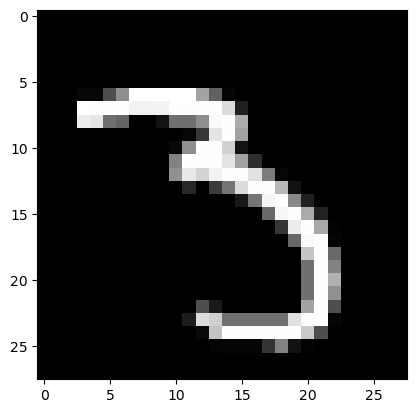

正解は:3
予測結果は:9
[[ 0.06300187  0.01429133  0.03495493 ...  0.02776751 -0.05763921
  -0.00759787]
 [-0.03198095  0.01381795 -0.01824304 ...  0.06378109  0.00453257
   0.01435676]
 [ 0.06725538 -0.04813425 -0.04537446 ...  0.03989344 -0.04699669
  -0.01648516]
 ...
 [-0.02571133  0.02809776  0.10875591 ... -0.03597355  0.03074085
   0.01763069]
 [ 0.02699757 -0.03636457 -0.00686967 ... -0.00920771 -0.00089243
   0.02344971]
 [ 0.00097252 -0.03004448  0.00856151 ... -0.06824825  0.07191712
   0.02005035]]


In [15]:
# kadai1
import matplotlib.pyplot as plt
from pylab import cm

# シード値を固定する
np.random.seed(0)
# 画像サイズ
picture_size = 28 * 28
# 中間層の数
M = 50 
# 標準入力
i = int(input("0~9999の整数を入力してください:"))
# クラス数
C =10

# 784次元ベクトル
test_data = X[i].reshape(picture_size)

# 　d×M行列W1
W_1 = np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M))
# M次元ベクトルb1
b_1 = np.random.normal(0, 1/np.sqrt(picture_size), M)
# 中間層前の計算結果
dot_1 = np.dot(np.array(W_1).T, test_data) + b_1

y_1 = 1 / (1 + np.exp(-dot_1))

# C ×M行列W2
W_2 = np.random.normal(0, 1/np.sqrt(picture_size), (M, C))
# C次元ベクトルb2
b_2 = np.random.normal(0, 1/np.sqrt(picture_size), C)
# 出力層前の計算結果
dot_2 = np.dot(np.array(W_2).T, y_1) + b_2

#dot_2のうち、最大の要素
alpha = np.max(dot_2)

# ソフトマックス関数を適用した後のベクトル
softmax_vector = np.exp(dot_2 - alpha) / np.sum(np.exp(dot_2 - alpha))

# 結果
result = np.argmax(softmax_vector)

plt.imshow(X[i], cmap=cm.gray)
plt.show()
print("正解は:"+str(Y[i]))

print("予測結果は:"+str(result))

# print(W_2)
print(W_1)

In [ ]:
# kadai2
import random

# バッチサイズ
B = 100
# 0~9999でランダムにB個ミニバッチを選択する
random_elements = random.sample(range(10000), B)
# ミニバッチのインデックス
minibatch_index = np.array(random_elements)
# ミニバッチ
minibatch_list = X[minibatch_index]
minibatch_vector_list = []
for x in minibatch_list:
    y = x.reshape(picture_size)
    minibatch_vector_list.append(y)

minibatch_vector_list = np.array(minibatch_vector_list).T / 255
# 正解データ
correct_labels = Y[minibatch_index]
# one-hot vector表記
one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T

# print(one_hot)
class Neuralnet:
    def __init__(self, W_1, b_1, W_2, b_2, minibatch_vector_list, one_hot):
    #      one_hotを初期化
        self.one_hot = one_hot
    #     それぞれ1回目の線型の演算を行う
        self.dot_1_list = np.dot(np.array(W_1).T, minibatch_vector_list) + b_1[:, np.newaxis]
    #     シグモイド関数を適用する
        self.sigmoid = 1 / (1 + np.exp(-self.dot_1_list))
#         self.sigmoid = np.exp(min(self.dot_1_list, 0)) / (1 + np.exp(-abs(self.dot_1_list)))
    #     それぞれ2回目の線型の演算を行う
        self.dot_2_list = np.dot(np.array(W_2).T, self.sigmoid) + b_2[:, np.newaxis]
#     #     それぞれの最大要素を並べたベクトル
#         self.dot_2_list = self.dot_2_list.T
    #     dot_2_alpha_list = [dot_2 - np.max(dot_2) for dot_2 in dot_2_list]
        self.dot_2_alpha_list = self.dot_2_list - np.max(self.dot_2_list, axis=0)
        
    def onehot_vector(self):
        return self.one_hot

    def logistic(self):
        return self.sigmoid
    
    def softmax_list(self):
#         return [np.exp(dot_2_alpha)/np.sum(np.exp(dot_2_alpha)) for dot_2_alpha in self.dot_2_alpha_list]
        return np.exp(np.array(self.dot_2_alpha_list))/np.sum(np.exp(np.array(self.dot_2_alpha_list)), axis=0)
    
    def closs_entropy(self):
        
        log_before = np.exp(np.array(self.dot_2_alpha_list)) / np.sum(np.exp(np.array(self.dot_2_alpha_list)), axis=0)
        softmax_vector_list = -np.log(log_before)
        result = np.sum(self.one_hot * softmax_vector_list, axis=0)
        return np.sum(result) / B
    def expectations(self):
        softmaxs = np.exp(np.array(self.dot_2_alpha_list))/np.sum(np.exp(np.array(self.dot_2_alpha_list)), axis=0)
        return np.argmax(softmaxs, axis=0)
        

neuralnet = Neuralnet(W_1, b_1, W_2, b_2, minibatch_vector_list, one_hot)
# print(neuralnet.softmax_list())
print("クロスエントロピーは:"+str(neuralnet.closs_entropy()))
# print(neuralnet.expectations())
# print(neuralnet.logistic())
print(neuralnet.onehot_vector())

# print(neuralnet.sotmax_list)


# 以下、ミニバッチ
# print(neural_net(minibatch_vector_list))